이번 코스에서는 자연어 처리의 꽃이라 불리는 트랜스포머(Transformer) 에 대해 알아볼 겁니다! 

- 트랜스포머 이전의 Attention 기법에 대해 간단하게 복습한다.
- 트랜스포머에 포함된 모듈들을 심층적으로 이해한다.
- 트랜스포머를 발전시키기 위해 적용된 여러 테크닉들을 알아본다.

## Attention 의 역사

Sequence-to-sequence(Seq2seq)는 신경망 언어 모델, 특히 기계번역에서 혁신적인 발전을 이룩해냈습니다. 

기존의 단일 RNN은 번역에 적합한 구조가 아니었으나 두 개의 RNN을 결합한 Encoder-Decoder 구조를 만들어 문맥 전체를 반영한 번역이 가능하게 했죠.

하지만 고정된 크기의 컨텍스트 벡터를 사용하는 것은 필연적으로 정보의 손실을 야기합니다. 

그래서 모든 단어를 같은 비중으로 압축하지 말고, 번역하는 데에 중요한 단어만 큰 비중을 줘서 성능을 높여보자며 Dzmitry Bahdanau가 Attention을 제안합니다.

하지만 Bahdanau Attention의 문제라면 T 스텝에서 Decoder의 Hidden State를 구하기 위해 T-1 스텝의 Hidden State를 사용해야 한다는 것이었죠. 

이는 재귀적으로 동작하는 RNN에 역행하는 연산이므로 효율적이지 못했습니다. 이를 개선하고자 한 것이 Luong이 제안한 Attention 기법입니다!

그리고 2017년, 이 흐름을 종결하기라도 하려는 듯 Attention Is All You Need 라는 충격적인 제목의 논문이 등장합니다.  
https://arxiv.org/pdf/1706.03762.pdf 참고

## Attention Is All You Need!

충격적인 논문의 한 구절

We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.

(우리는 RNN과 CNN을 완전히 배제하고 Attention 메커니즘에만 기반을 둔 새롭고 단순한 구조, Transformer를 제안합니다.)*

생각해 보면 그간 RNN은 많은 발전을 거듭했지만 그럼에도 고질병인 기울기 소실(Vanishing Gradient) 은 완벽히 해결되지 않았습니다. 

저자들은 문장에서 연속성이라는 개념을 과감히 배제 하였습니다.  
대신 Attention으로 각 단어들의 상관관계를 구하는 데 집중 하였죠. 

<b>RNN처럼 단어 입력을 순차적으로 처리하지도 않으면서 어떻게 문장을 정확히 처리해냈는지는 차근차근 이해해 보도록 하죠!</b>

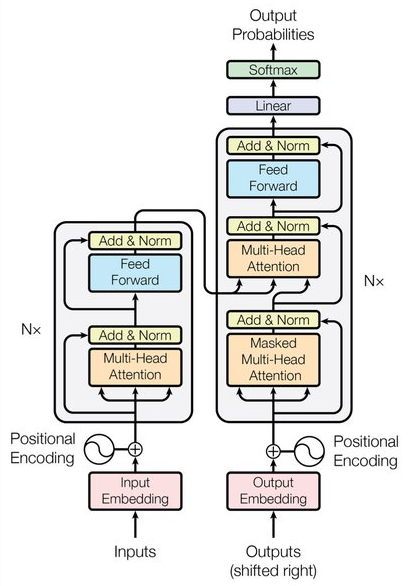

In [1]:
from IPython.display import Image
Image(filename='capture/10_transformer_architecture.png') 

- 트랜스포머도 엄밀하게는 Seq2seq에서 제안된 Encoder-Decoder 구조를 사용합니다. 대신 그 안에는 LSTM 대신 다양한 모듈들이 가득 차 있죠. 
- 그리고 이 멋진 Encoder와 Decoder를 여러 개(논문에서는 6개) 쌓아올려 모델을 완성합니다.

- 가끔 헷갈려 하시는 분들이 있어 첨언하면, Enc-Dec-Enc-Dec-... 구조가 아닌 Enc-Enc-...-Dec-Dec-... 구조입니다!

모델 최하단에 위치한 Positional Encoding 부터 알아보자.

## Positional Encoding

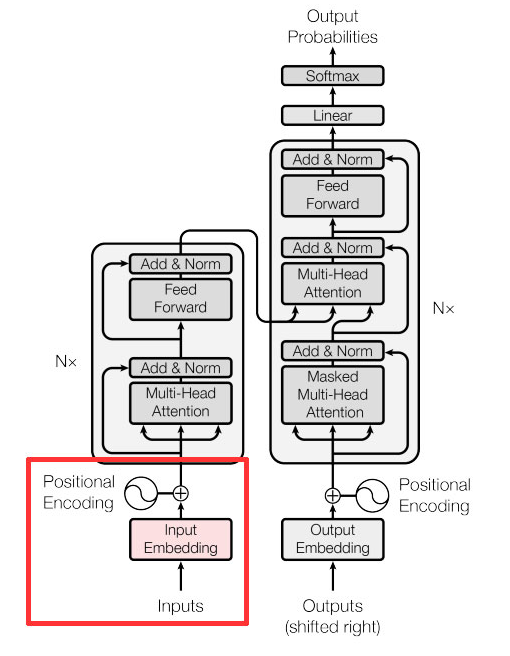

In [6]:
from IPython.display import Image
Image(filename='capture/13_section_positional_encoding.png') 

문장의 연속성을 배제하면 "빨간 사과 노란 바나나" 와 "노란 사과 빨간 바나나" 를 같은 문장으로 간주할 것이다.

Positional Encoding 은 그런 불상사를 막기 위한 방법이다. 즉, <b>문장에 연속성을 부여하는 새로운 방법을 제시</b>한 것이다.

https://skyjwoo.tistory.com/31 참고

저자가 제시한 Positional Encoding의 두 가지 방법과 그 한계는 각각 무엇인가요?
- 1) 데이터에 0~1사이의 label을 붙인다. 0이 첫번째 단어, 1이 마지막 단어
  - → I love you: I 0 /love 0.5/ you 1
  - → Input의 총 크기를 알 수 없다. 따라서 delta 값이 일정한 의미를 갖지 않는다.(delta = 단어의 label 간 차이)
- 2) 각 time-step마다 선형적으로 숫자를 할당하는 것이다.(총 크기에 따라 가변적, delta일정해짐) 따라서 첫번째 단어 는 1, 두 번째 단어는 2를 갖게 됨
  - → I love you: I 1/ love 2/you 3
  - → 숫자가 매우 커질 수 있고, 훈련 시 학습할 때보다 큰 값이 입력값으로 들어오게 될 때 문제 발생 모델의 일반화 가 어려워짐-특정한 범위 값을 갖는게 아니기에

저자는 이상적인 모델은 다음과 같은 기준을 충족시켜야 한다고 말한다.
- 1) 각 time-step(문장에서 단어의 위치)마다 하나의 유일한 encoding 값을 출력해 내야 한다. 
- 2) 서로 다른 길이의 문장에 있어서 두 time-step 간 거리는 일정해야 한다.
- 3) 모델에 대한 일반화가 가능해야 한다. 더 긴 길이의 문장이 나왔을 때 적용될 수 있어야 한다. 즉, 순서를 나타내는 값 들이 특정 범위 내에 있어야 한다.
- 4) 하나의 key 값처럼 결정되어야 한다. 매번 다른 값이 나와선 안된다.

Positional Encoding 수식은 다음과 같다.

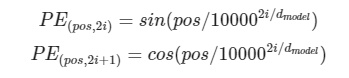

In [2]:
from IPython.display import Image
Image(filename='capture/13_positional_encoding.png') 

- pos는 단어가 위치한 Time-step을 의미하며 
- i는 Encoding 차원의 Index, 
- d model 은 모델의 Embedding 차원 수입니다. 

이를 <b>Sinusoid(사인파) Embedding</b>이라고 칭합니다. 이해를 돕기 위해 실제 구현을 확인해보자.

In [3]:
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


Position 값이 각 Time-step 별로 고유하다는 것을 시각화를 통해 확인해 볼 수 있습니다.

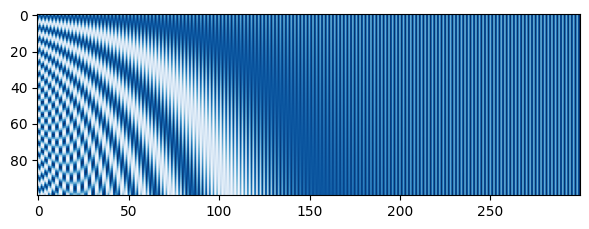

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

저자들은 이뿐만 아니라 Positional Embedding 기법도 제안했습니다. 

수식적으로 계산한 Position 값이 아니라 Position에 대한 정보를 담은 Embedding 레이어를 선언하여 위치에 대한 정보를 학습할 수 있게 한 거죠.

그림으로 표현하면 아래와 같습니다.

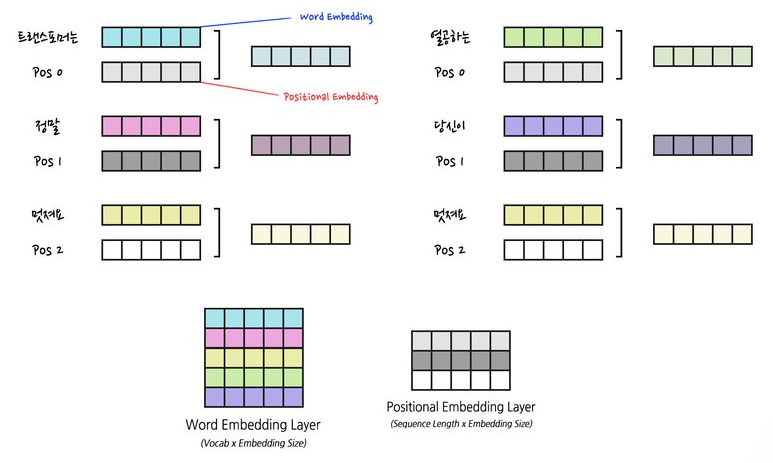

In [5]:
from IPython.display import Image
Image(filename='capture/13_positional_embedding.png') 

위와 같은 구조에서 Positional Embedding이 훈련 중 값이 변한다고 하더라도 그것은 모든 문장에 대해 동일하게 적용되기에 문제가 되지 않습니다.

오히려 Sinusoid Embedding보다 적합한 값이 학습될 것을 기대할 수도 있죠!

하지만 실제로는 두 방법 모두 거의 동일한(±0.1 BLEU) 결과를 보였으며, 저자들은 길이가 길어져도 부담이 없는 <b>Sinusoid(사인파) Embedding</b>을 채택하였습니다. 

Positional Embedding은 문장의 길이만큼 Embedding Table의 크기가 커지니까요.  
Positional Embedding은 추후에 BERT라는 모델에 적용되어 멋진 성능을 보여줄 예정입니다!

## Multi-Head Attention

트랜스포머의 핵심으로 꼽히는 멀티헤드 어텐션 -> Positional Embedding 된 문장으로부터 Attention 을 추출하는 부분이다!

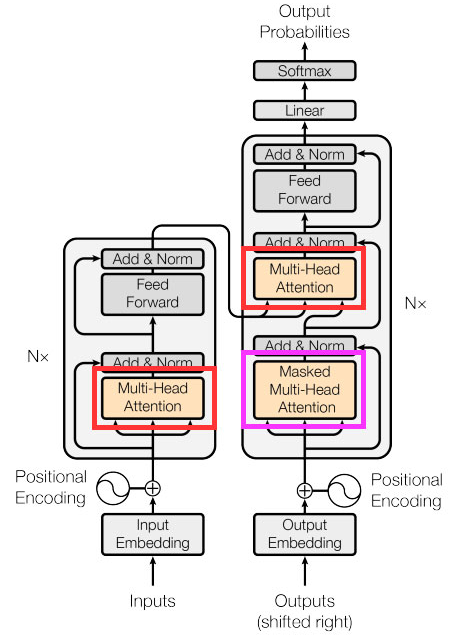

In [7]:
from IPython.display import Image
Image(filename='capture/13_section_multi_head_attention.png') 

보라색으로 표시된 Masked Multi-Head Attention은 
- Multi-Head Attention과 동일하지만 인과 관계 마스킹(Causality Masking) 이라는 과정이 하나 더 추가된다.

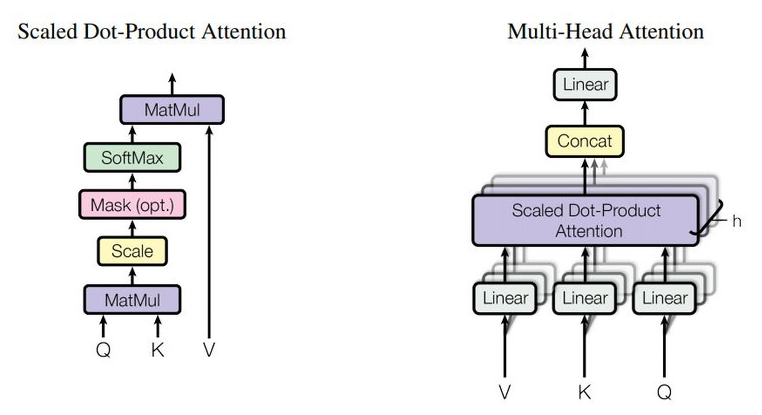

In [1]:
from IPython.display import Image
Image(filename='capture/13_multi-head_attention_module.png') 

Multi-Head Attention 모듈은 
- Linear 레이어와 Scaled Dot-Product Attention 레이어로 이루어집니다.

### Scaled Dot-Product Attention

논문에는 Q(query), K(key), V(value)가 어떤 의미를 가지고 있는지 특별한 설명이 없다. 오히려 후속 연구들을 통해 밝혀지고 있다.

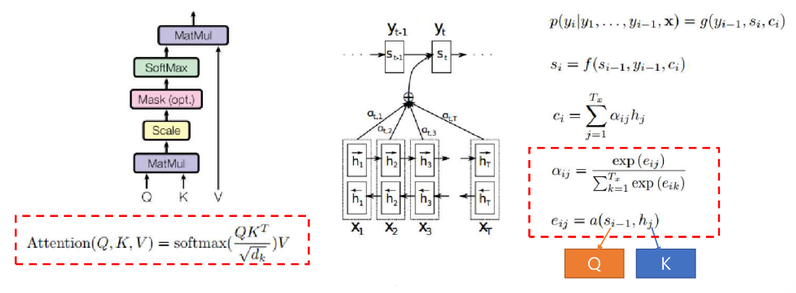

In [2]:
from IPython.display import Image
Image(filename='capture/13_attention_comparison.png') 

전통적인 attention 개념
- seq2seq 인코더-디코더 구조에서 attention 이란
  - 디코더의 포지션 i 에서 바라본 인코더의 context vector ci 를 해석하기 위해, 인코더의 각 포지션 j 에 부여한 가중치
  - 이 가중치는 디코더의 state si 와 인코더의 state hj 사이의 유사도를 통해 계산되었다.
  
Transformer 에서의 attention 개념
- 원리는 동일하다
  - 단지 디코더의 state를 Q(query) 라고 부르고, 인코더의 state를 K(key) 라고 추상화 한 것이다.
  - 그래서 Q 와 k 의 유사도를 dot product 로 계산해서 softmax 를 attention 가중치로 삼고 -> 이것으로 V(value)를 재해석 해 준 것이다.
  
다른점 하나는, 인코더 쪽에서 hj 하나만 존재하던 것이 K 와 V 2가지로 분화되었다는 점이다.

조금 더 자세한 설명은 https://reniew.github.io/43/ 참고

Query와 Key를 Dot-Product한 후 Softmax를 취하는 것은 어떤 의미를 가지나요?
- 하나의 Query와 모든 Key들 사이의 연관성(유사도)을 계산한 후 그 값을 확률 값으로 만든다. 이는 Query가 어떤 Key와 높은 확률로 연관이 있는 지 계산한다.

트랜스포머의 Attention은 위의 식으로 Attention 값을 나눠준다는 것에서 "Scaled" Dot-Product Attention이라고 불립니다. 이 Scale 과정은 어떤 의미를 가지나요? (또는, 왜 필요한가요?)
- Embedding 차원 수가 깊어지면 깊어질수록 Dot-Product의 값은 커지게 되어 Softmax를 거치고 나면 미분 값이 작아지는 현상이 나타난다. 그 경우를 대비해 Scale 작업이 필요하다.

[정리]

Scaled Dot-Product Attention 은
- Additive(합 기반) Attention 과 Dot-Product(=Multiplicative, 곱 연산 기반) Attention 중 후자를 사용한 Attention
- 차원 수가 깊어짐에 따라 Softmax 값이 작아지는 것을 방지하기 위해 Scale 과정을 포함

이 과정을 본떠 <b>Scaled Dot-Product Attention</b> 이라고 이름이 붙여짐

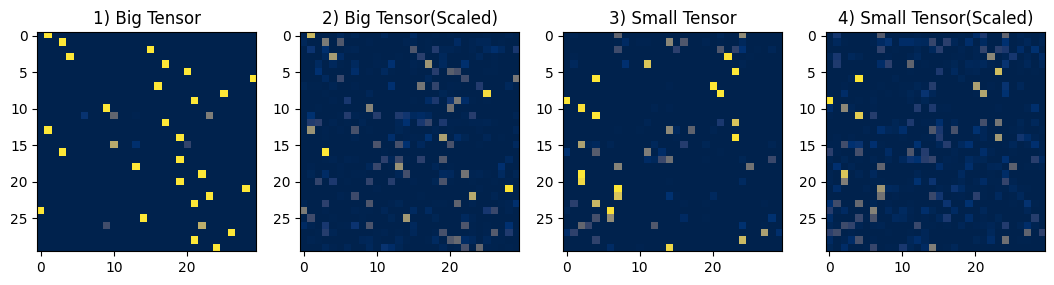

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('1) Big Tensor')
ax2.set_title('2) Big Tensor(Scaled)')
ax3.set_title('3) Small Tensor')
ax4.set_title('4) Small Tensor(Scaled)')

ax1.imshow(tf.nn.softmax(big_tensor, axis=-1).numpy(), cmap='cividis')
ax2.imshow(tf.nn.softmax(scaled_big_tensor, axis=-1).numpy(), cmap='cividis')
ax3.imshow(tf.nn.softmax(small_tensor, axis=-1).numpy(), cmap='cividis')
ax4.imshow(tf.nn.softmax(scaled_small_tensor, axis=-1).numpy(), cmap='cividis')

plt.show()

모두 같은 범위인 [-3, 3]에서 랜덤 Tensor를 만들어 실제 Attention을 하듯 Dot-Product를 하고, Softmax를 취했습니다. 

위 히트맵에서 어두운 부분으로는 미분 값(Gradient) 이 흐르기 어렵기 때문에 모델이 넓은 특성을 반영할 수 없게 됩니다.  
즉, 히트맵이 선명할수록 모델의 시야가 편협해진다 고 이해하시면 좋아요!

위 시각화를 통해 Embedding의 깊이가 깊을수록 모델의 시야가 편협해지는 문제가 생기고[1, 3],  
Scale은 그 문제의 훌륭한 해결책임을 확인할 수 있습니다[2, 4]

심지어 깊이에 무관하게 일정한 결과를 만들어내므로 어떤 경우에도 적용할 수 있는 훌륭한 Attention 기법이 탄생했음을 알 수 있습니다!

### 인과 관계 마스킹 (Causality Masking)

Sequence-to-sequence 모델을 훈련할 때에 Decoder의 첫 입력으로 <start> 토큰이 들어가던 것을 기억하실 겁니다.
- 즉 `<start>` 토큰만을 단서로 첫 번째 단어를 생성해야 하죠. 
- 이 같은 특성을 <b>자기 회귀(Autogressive)</b> 라 칭한다.

하지만 트랜스포머는 모든 단어를 병렬적으로 처리하기에 자기 회귀적인 특성을 잃어버립니다.  
이는 곧 문장을 생성할 수 없다는 의미이고, 쓸모가 없다는 얘기죠!
    
이에 저자들이 자기 회귀적인 특성을 살리기 위해 추가한 것이 바로 인과 관계 마스킹(Causality Masking) 입니다.  
인과 관계 마스킹은 목표하는 문장의 일부를 가려 인위적으로 연속성을 학습 하게 하는 방법입니다.

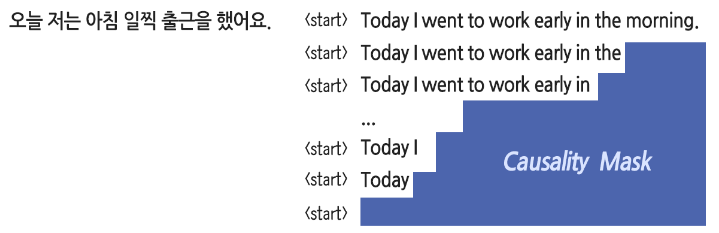

In [4]:
from IPython.display import Image
Image(filename='capture/13_causality_masking.png') 

위와 같은 과정을 거치면 모든 Time-Step에 대한 입력을 한 번에 처리하면서 자기 회귀적인 특성도 유지하게 됩니다. 
- 테스트 시 소스 문장을 Encoder에 전달하고 타겟 문장은 `<start>`만 넣더라도 모델이 `<start>` 토큰만 보고 문장을 생성한 적(위 그림의 마지막 Step)이 있기 때문에 첫 번째 단어를 생성해낼 수 있고, 생성된 단어는 다시금 입력으로 전달되어 그야말로 자기 회귀적으로 문장을 생성하게 됩니다.

이러한 연유로 인과 관계 마스크는 대각항을 포함하지 않는 삼각 행렬의 모양새를 갖습니다.

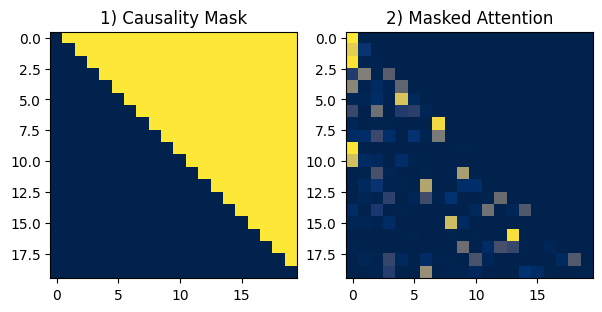

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

좌측은 실제 마스크의 형태, 우측은 마스킹이 적용된 Attention입니다.  
마스킹은 마스킹 할 영역을 -∞로 채우고 그 외 영역을 0으로 채운 배열을 Dot-Product된 값에 더해주는 방식으로 진행됩니다.  
후에 진행될 Softmax는 큰 값에 높은 확률을 할당하는 함수이므로 -∞로 가득 찬 마스킹 영역에는 무조건 0의 확률을 할당하게 됩니다.

### Multi-Head Attention

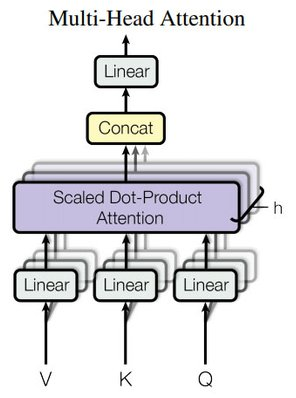

In [6]:
from IPython.display import Image
Image(filename='capture/13_multi-head_attention.png') 

Scaled Dot-Product Attention에서 정말 많은 이야기를 했는데, 그것을 이해하고 나면 정작 Multi-Head Attention 모듈은 간단합니다.  
일전에 Embedding이 어떤 추상적인 속성을 담고 있다고 배웠던 것, 기억하시나요? Multi-Head Attention은 그 개념을 활용해서 이해를 하면 아주 쉽습니다.

바나나라는 단어가 512차원의 Embedding을 가진다고 가정합시다.  
- 그중 64차원은 노란색에 대한 정보를 표현하고, 다른 64차원은 달콤한 맛에 대한 정보를 표현할 겁니다. 
- 같은 맥락으로 바나나의 형태, 가격, 유통기한까지 모두 표현될 수 있겠죠. 
- 저자들은 '이 모든 정보들을 섞어서 처리하지 말고, 여러 개의 Head로 나누어 처리하면 Embedding의 다양한 정보를 캐치할 수 있지 않을까?' 라는 아이디어를 제시합니다.

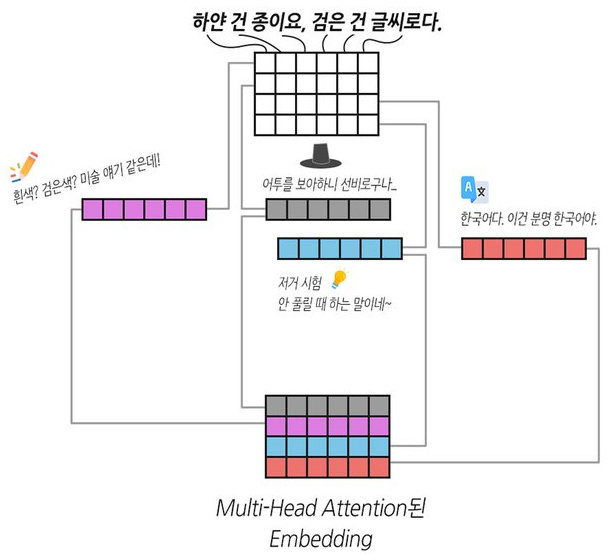

In [7]:
from IPython.display import Image
Image(filename='capture/13_multi-head_attention_embedding.png') 

Multi-Head Attention에서 Head는 주로 8개를 사용합니다. 
- Embedding된 10개 단어의 문장이 [10, 512]의 형태를 가진다면, Multi-Head Attention은 이를 [10, 8, 64]로 분할하여 연산합니다. 
- 각 64차원의 Embedding을 독립적으로 Attention한 후, 이를 이어붙여 다시금 [10, 512]의 형태로 되돌리며 연산은 끝이 납니다.

쪼개진 64차원이 연관 있는 것들끼리 묶여있을까?
- Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 앞단에 Linear 레이어를 추가해 주는 겁니다.
- Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도 Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑합니다.

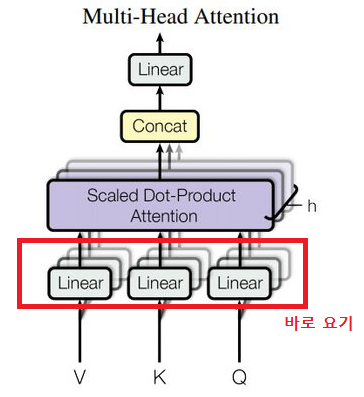

In [8]:
from IPython.display import Image
Image(filename='capture/13_linear_in_multi-head_attention.png') 

비슷한 이유로 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없습니다. 

따라서 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치며 비로소 Multi-Head Attention이 마무리가 됩니다.

## Position-wise Feed-Forward Networks

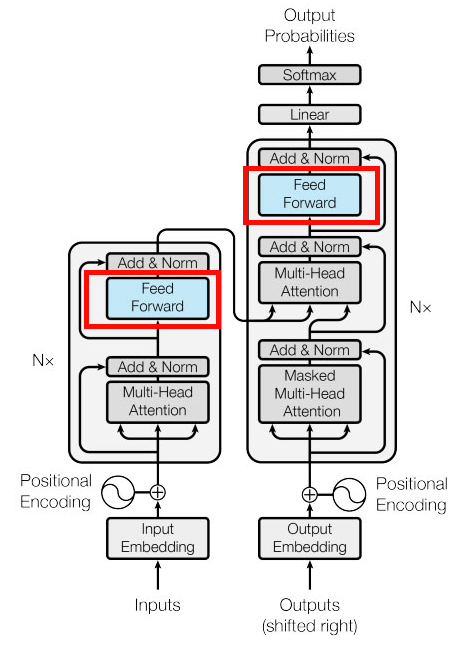

In [9]:
from IPython.display import Image
Image(filename='capture/13_feed_forward.png') 

논문의 구절을 그대로 보자.

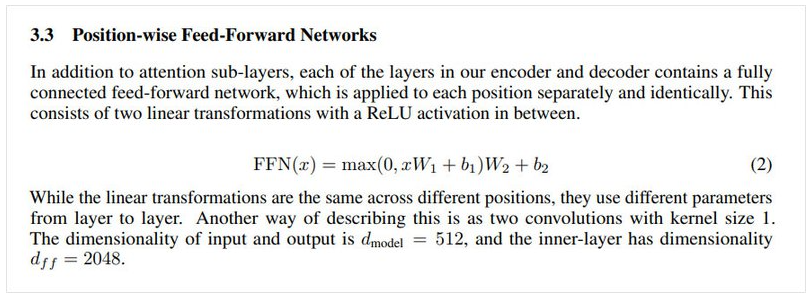

In [10]:
from IPython.display import Image
Image(filename='capture/13_position-wise_feed-forward_networks.png') 

W는 Linear 레이어를 의미하고, max(0, x) 함수는 활성 함수 ReLU입니다. 

예를 들면 10단어로 이루어진 Attention된 문장 [10, 512]를 [10, 2048] 공간으로 매핑, 활성함수를 적용한 후 다시 [10, 512] 공간으로 되돌리는 것입니다.

https://pozalabs.github.io/transformer/ 참고 (Position-wise Feed-Forward Networks 부분)

transfomer는 recurrence도 아니고 convolution도 아니기 때문에, 단어의sequence를 이용하기 위해서는 단어의 position에 대한 정보를 추가해줄 필요가 있었습니다.

그래서 encoder와 decoder의 input embedding에 positional encoding을 더해줬습니다.

FFN 연산이 개별 단어(Position)마다 적용되기 때문에 FFN 앞에 Position-Wise 라는 수식이 붙었다.

## Additional Techniques

여기까지 트랜스포머의 큰 줄기를 다뤘다. 이제 세부 줄기에 대해서 살펴볼 것이다.

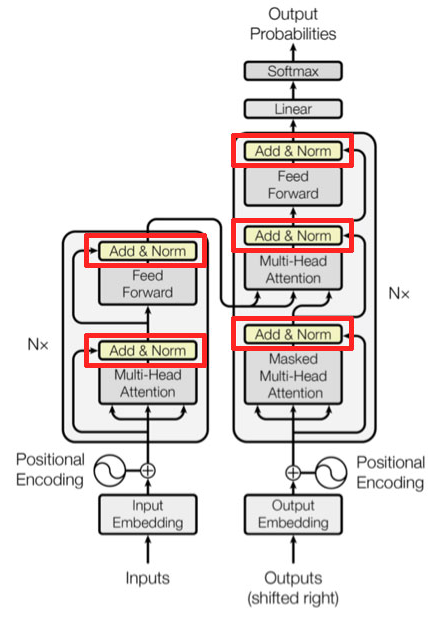

In [11]:
from IPython.display import Image
Image(filename='capture/13_add&norm.png') 

### Layer Normalization

Layer Normalization은 데이터를 Feature 차원에서 정규화를 하는 방법입니다. 

또다시 10단어의 Embedding된 문장을 예로 [10, 512]에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰주는 것이죠. 

참고로, Normalization 에 대한 다양한 방법들에 대해  
https://subinium.github.io/introduction-to-normalization/ 여기서 확인 가능하다.

Batch Normalization과 Layer Normalization의 차이점
- BN 과 LN 은 각각  Batch 차원에서 정규화 / Feature 차원에서 정규화 라는 차이가 있다.

### Residual Connection

Skip Connection 이라고도 부르는 Residual Connection 이 처음 제안된 것은 2015년 ResNet 이라는 모델과 함께였다.

https://itrepo.tistory.com/36 참고

상식적으로 56개의 레이어를 갖는 네트워크는 20개의 레이어를 갖는 네트워크보다 성능이 좋아야 합니다. 하지만 그렇지 않았죠! 이유가 무엇인가요?
- 네트워크가 깊어질 수록 Optimize(Train)하는 것이 어렵기 때문에, 얕은 네트워크가 더 좋은 성능을 보이게 된다.

Residual Block은 굉장히 간단한 수식으로 표현이 가능합니다. 수식을 적어보세요.
- y = f(x) + x

### Learning Rate Scheduler

트랜스포머를 훈련하는 데에는 Adam Optimizer 를 사용했는데, 특히한 점은 Learning Rate 를 수식에 따라 변화시키며 사용했다는 것이다.

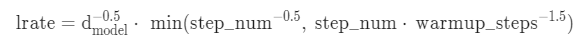

In [12]:
from IPython.display import Image
Image(filename='capture/13_transformer_learning_rate.png') 

warmup_steps까지는 lratelrate가 선형적으로 증가 하고, 이후에는 step\_numstep_num에 비례해 점차 감소하는 모양새 를 보이게 됩니다

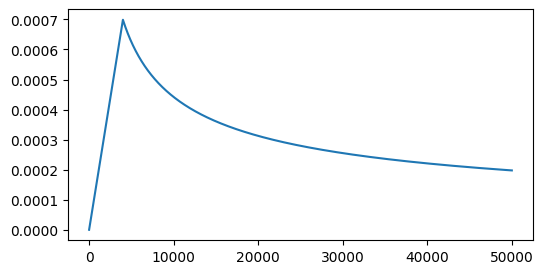

In [13]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(1, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)])
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

이와 같은 Learning Rate를 사용하면 초반 학습이 잘되지 않은 상태에서의 학습 효율이 늘어나고, 어느 정도 학습이 된 후반에는 디테일한 튜닝을 통해 Global Minimum을 찾아가는 효과가 나게 됩니다. 

학습의 초반과 후반은 warmup_steps 값에 따라 결정되고요. 직관적으로도 멋진 개념입니다!

### Weight Sharing

Weight Sharing은 모델의 일부 레이어가 동일한 사이즈의 Weight를 가질 때 종종 등장하는 테크닉입니다. 
- 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하도록 하는 것인데, 대표적으로 언어 모델의 Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 Weight를 가집니다. 
- 프로그래밍 개념 중 Call By Reference와 비슷한 느낌이죠!

이는 가볍게 생각했을 때에는 비효율적일 것으로 보입니다. 
- 출력층의 Linear 레이어는 그만의 역할이 있을 것이고 Embedding 레이어 또한 그럴 것인데, 둘을 서로 엮어버리면 이도 저도 아닐 것 같은 느낌이 들죠. 

하지만 앞서 ResNet이 증명한 것처럼 많은 Weight가 곧 성능으로 이어지지 않고, 외려 Optimization에서 불리한 경향을 보인다는 것을 생각하면 이해가 갈 거예요.

실제로 Weight Sharing은 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 더 유리하며 자체적으로 Regularization 되는 효과도 있습니다.  
유연성이 제한되어 과적합을 피하기 용이해지거든요!

트랜스포머에서는 Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유하는 방식을 사용했습니다. 
- 소스 Embedding과 타겟 Embedding도 논문상에서는 공유했지만 이는 언어의 유사성에 따라서 선택적으로 사용합니다. 
- 만일 소스와 타겟 Embedding 층까지 공유한다면 3개의 레이어가 동일한 Weight를 사용하는 셈이죠.

또한 출력층 Linear 레이어와 Embedding 레이어의 Feature 분포가 다르므로 Embedding 된 값에 dmodel 의 제곱근 값을 곱해줍니다.  
이는 분포를 맞춰줌과 동시에 Positional Encoding이 Embedding 값에 큰 영향을 미치는 것을 방지해 줍니다.

## 트랜스포머, 그 후엔

트랜스포머가 NLP의 꽃이라는 것은 학계의 수많은 관련 논문들이 증명합니다!.  
이번 스텝에서는 트랜스포머를 기반으로 발전한 큰 줄기들을 간단하게 소개해 드리겠습니다.

가장 먼저 등장한 것은 BERT와 GPT였습니다. 두 모델 다 엄청난 양의 데이터를 기반으로 훈련되어 경이로운 성능을 보여줬죠. 

https://ratsgo.github.io/nlpbook/docs/language_model/bert_gpt/#gpt 참고

GPT와 BERT의 차이점에 대해 3가지만 적어보세요.
- GPT는 단방향 Attention을 사용하지만 BERT는 양방향 Attetion을 사용한다.
- GPT는 트랜스포머에서 디코더(decoder)만 사용하고 BERT는 인코더(encoder)만 사용한다.
- GPT는 문장을 생성할 수 있지만 BERT는 문장의 의미를 추출하는 데 강점을 가지고 있다.

오늘 소개한 트랜스포머는 max_sequence_length를 512에서 1024 정도로만 사용합니다. 

그래서 초기에는 주로 몇 개 문장 단위의 번역 작업에 활용되었죠. 문단의 문맥을 파악하는 수준까지의 보다 긴 입력 길이를 처리할 수 있도록, 기존의 트랜스포머에 Recurrence라는 개념을 추가한 Transformer-XL이 제안되기도 했습니다.  
https://comeng.tistory.com/entry/Transformer-XL-%EC%9E%90%EB%A3%8C%EC%A0%95%EB%A6%AC-%EB%B0%8F-%EC%84%A4%EB%AA%85%EC%9A%94%EC%95%BD 참고

Reformer는 트랜스포머를 연산량 측면에서 혁신적으로 개선한 모델  
https://brunch.co.kr/@synabreu/31 참고

이 흐름에서 등장한 재미있는 아이디어 중 하나는 "Multi-Head Attention에서 모든 Head가 과연 필요한가?" 라는 주장  
https://www.facebook.com/permalink.php?story_fbid=156092245822648&id=111809756917564 참고
https://littlefoxdiary.tistory.com/m/66?category=847374 참고

이 외에도 XLNet, ELECTRA, RoBERTa, GPT-3... 놀라운 것들은 너무나도 많지만 우리에게 주어진 시간이 한정적이니 필요한 것을 빠르게 훑는 기술도 필요하겠죠. 위에 소개해드린 큰 줄기 중 관심이 동하는 부분이 있다면 그쪽으로 파생된 모델들을 차근차근 훑어가는 것도 좋은 공부가 될 것 같네요!